In [68]:
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

import scipy.io
import scipy.signal
import scipy.ndimage.filters as scifilt
from scipy.interpolate import interpn

import nibabel
import sys
import warnings

def norm(v,axis=0):
    return np.sqrt(np.sum(v**2,axis=axis))
    
def abshilbert(x, axis=-1):
    return np.abs(scipy.signal.hilbert(x,axis=axis))

np.set_printoptions(precision=4, suppress=True)

In [2]:
%matplotlib inline

#### Function used for finding signal boundaries:

In [80]:
def find_start_index(data, t_mask, sigma=5, axis=-1, percentile=None, retall=False):
    """
    Input 1D data and a background mask (t_mask). Find the time when net signal exceeds percentile or sigma.
    """
    background = np.abs(data[t_mask])
    
    
    bg_avg = np.mean(background, axis=axis)
    bg_std = np.std(background, axis=axis)
    
    netsum = np.cumsum((np.abs(data) - bg_avg), axis=axis) 
    
    bg_avg /= netsum[-1]
    bg_std /= netsum[-1]
    
    netsum /= netsum[-1]
    
    
    if percentile is not None:
        signal = netsum >= percentile
    else:
        signal = (np.abs(data) - np.mean(background, axis=axis)) >= (sigma*bg_std)
    
    if len(signal)==0:
        starti=-1
    else:
        starti = np.nonzero(signal)[axis][0]
    
    if retall:
        return (netsum,bg_avg,bg_std, starti, signal)
    else:
        return starti

# Load hydrophone data

In [10]:
trc_1mm = scipy.io.loadmat('Water/H115_freefield_802kHz_25mV_LegoA.mat',squeeze_me=True)

trig_delay = trc_1mm['delay_samp']
dt = trc_1mm['dt']
Ns = trc_1mm['Ns']
hydrophone_data = trc_1mm['volts']

timebase_us = (trig_delay + np.arange(Ns))*dt*1e6

print('Beam map shape (voxels x time):', hydrophone_data.shape)

Beam map shape (voxels x time): (34, 30, 30, 1042)


# Create digital filter

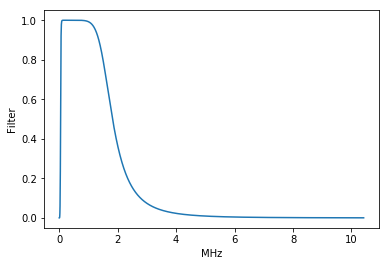

In [7]:
#create filter
ni = Ns
delta_t = dt

NFFT = 2**np.ceil(np.log2(ni)).astype(int)

fx = np.linspace(0.0, 1.0, NFFT)/delta_t

b,a=scipy.signal.butter(4,2*np.pi*np.array([50e3, 1600e3]), btype='bandpass', analog=True)
w,hfilt=scipy.signal.freqs(b,a,worN=fx*2*np.pi)
hfilt=np.abs(hfilt)

def filter1d(data):
    data_ft = np.fft.fft(data,n=NFFT)
    return 2.0*np.real(np.fft.ifft(data_ft*hfilt, n=NFFT)[0:ni])


plt.plot(fx*1e-6, hfilt)
plt.xlabel('MHz')
plt.ylabel('Filter')

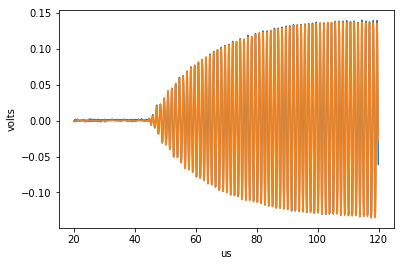

In [85]:
data = hydrophone_data[20,13,13]

filt_data = filter1d(data)

plt.plot(timebase_us, data)
plt.plot(timebase_us, filt_data)
plt.xlabel('us')
plt.ylabel('volts')

# Three methods for signal selection: 

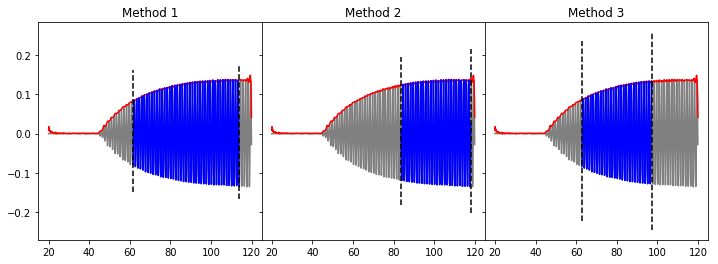

In [86]:

bg_mask = timebase_us < 30.0

#Method1
def Method1(filt_data):
    """
    Find indices corresponding to specified percentile of total signal
    """
    
    sa = find_start_index(filt_data, bg_mask, percentile=0.1)
    sb = find_start_index(filt_data, bg_mask, percentile=0.9)

    if sa==-1:
        sa=0
        sb=Ns-1
    return (sa,sb)


Ncyc = 30 #number of cycles to integrate if using Method2 or Method3 below
signal_f0 = 802e3 #center freq
integral_size= int(1/(delta_t*signal_f0))*Ncyc

#Method2
def Method2(filt_data):
    """
    Start from the end (si), and integrate backwards Ncyc 
    """
    si = Ns-8
    sb = si - int(1/(delta_t*signal_f0))
    sa = sb - integral_size + 1
    return (sa,sb)

#Method3
def Method3(filt_data):
    """
    Find first index corresponding to specified percentile of total signal observed, then count forward Ncyc cycles
    """
    ramp_cyc_delay = 1*int(1/(delta_t*signal_f0))
    sa = find_start_index(filt_data, bg_mask, percentile=0.10) + ramp_cyc_delay
    sb = sa + integral_size
    if sb > Ns:
        sb = Ns - int(1/(delta_t*signal_f0))
    return (sa,sb)


fig,axs = plt.subplots(1,3,figsize=(12,4),sharey=True, gridspec_kw=dict(wspace=0.0))


methods = [Method1, Method2, Method3]

for i in range(3):
    f = methods[i]
    
    (sa,sb) = f(filt_data)
    
    plt.sca(axs[i])
    plt.title('Method %d'%(i+1))
    
    envelope = abshilbert(filt_data)
    
    plt.plot(timebase_us, (filt_data), color=(0.5,.5,.5))
    plt.plot(timebase_us, envelope, 'r')
    plt.plot(timebase_us[sa:sb], filt_data[sa:sb], 'b')
    plt.plot(timebase_us[[sa,sa]],plt.ylim(),'k--')
    plt.plot(timebase_us[[sb,sb]],plt.ylim(),'k--')

# Apply one of the methods to compute scalar field values:

In [83]:
(nx,ny,nz) = hydrophone_data.shape[0:3]

P_rms = np.zeros((nx,ny,nz))

for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            data = hydrophone_data[i,j,k]
            filt_data = filter1d(data)
            
            try:
                (sa,sb) = Method2(filt_data)
                if sb > Ns:
                    sb = Ns
            except(IndexError):
                sa=0; sb=1
                
            P_rms[i,j,k] = np.mean((filt_data[sa:sb])**2)


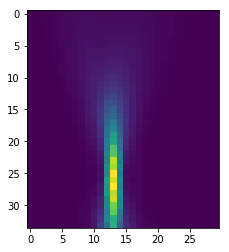

In [84]:
plt.imshow(P_rms[:,13,:])